In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import sys
sys.path.insert(1,'../')
from oml.angles import rotations_equal

# Loss statistics

In [37]:
df = pd.read_csv("../results/alignment/loss.csv")
df['seed'] = df.seed.astype(int)
prop_good = (df['final_loss'] < 0.1).mean() * 100
print(f"Initializations with good convergence: {prop_good:.2f} %")

Initializations with good convergence: 63.00 %


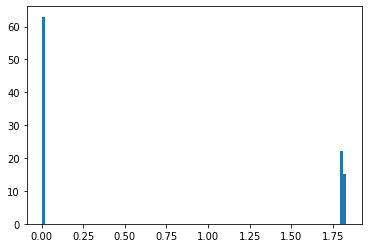

In [4]:
plt.hist(df['final_loss'], bins=100)
plt.show()

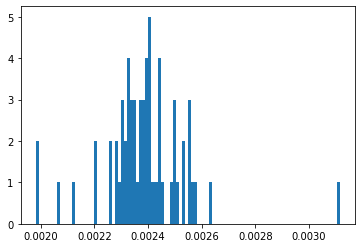

In [5]:
plt.hist(df.loc[df.final_loss < 0.1,'final_loss'], bins=100)
plt.show()

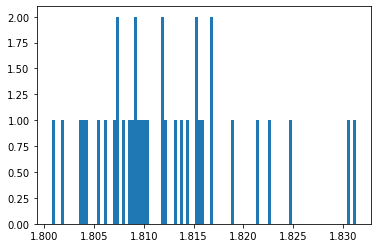

In [6]:
plt.hist(df.loc[df.final_loss > 0.1,'final_loss'], bins=100)
plt.show()

# Critical points (R)

In [39]:
df['good_conv'] = (df['final_loss'] < 0.1)
n_runs = 100
trajectories = {}
critical_points = np.zeros([n_runs, 6])
for i in range(n_runs):
    trajectories[i] = np.load(f'../results/alignment/trajectories/{i}.npy')
    critical_points[i, :] = trajectories[i][-1, :]
df['norm_cp'] = (critical_points**2).sum(1)**(1/2)

In [46]:
seed_order = df.loc[df.good_conv].sort_values('norm_cp').seed.values
unique_good_R = []
for seed in seed_order:
    equal = False
    for r in unique_good_R:
        if rotations_equal(r, critical_points[seed, :]):
            equal = True
            break
    if not equal:
        unique_good_R += [critical_points[seed, :]]

In [47]:
unique_good_R

[array([ 4.3201825 ,  0.55304593,  2.78951382, -0.07910504,  0.58023999,
         0.68084799])]

In [48]:
seed_order = df.loc[~df.good_conv].sort_values('norm_cp').seed.values
unique_bad_R = []
for seed in seed_order:
    equal = False
    for r in unique_bad_R:
        if rotations_equal(r, critical_points[seed, :]):
            equal = True
            break
    if not equal:
        unique_bad_R += [critical_points[seed, :]]

In [50]:
len(unique_bad_R)

34

In [52]:
len(df.loc[~df.good_conv])

37

# Trajectories

In [58]:
def from_spherical_coords(theta_phi, phi=None):
    """Return the quaternion corresponding to these spherical coordinates

    Assumes the spherical coordinates correspond to the quaternion R via

        R = exp(phi*z/2) * exp(theta*y/2)

    The angles naturally must be in radians for this to make any sense.

    Note that this quaternion rotates `z` onto the point with the given
    spherical coordinates, but also rotates `x` and `y` onto the usual basis
    vectors (theta and phi, respectively) at that point.

    Parameters
    ----------
    theta_phi: float or array of floats
        This argument may either contain an array with last dimension of
        size 2, where those two elements describe the (theta, phi) values in
        radians for each point; or it may contain just the theta values in
        radians, in which case the next argument must also be given.
    phi: None, float, or array of floats
        If this array is given, it must be able to broadcast against the
        first argument.

    Returns
    -------
    R: quaternion array
        If the second argument is not given to this function, the shape
        will be the same as the input shape except for the last dimension,
        which will be removed.  If the second argument is given, this
        output array will have the shape resulting from broadcasting the
        two input arrays against each other.

    """
    # Figure out the input angles from either type of input
    if phi is None:
        theta_phi = np.asarray(theta_phi, dtype=np.double)
        theta = theta_phi[..., 0]
        phi  = theta_phi[..., 1]
    else:
        theta = np.asarray(theta_phi, dtype=np.double)
        phi = np.asarray(phi, dtype=np.double)

    # Set up the output array
    R = np.empty(np.broadcast(theta, phi).shape + (4,), dtype=np.double)

    # Compute the actual values of the quaternion components
    R[..., 0] =  np.cos(phi/2)*np.cos(theta/2)  # scalar quaternion components
    R[..., 1] = -np.sin(phi/2)*np.sin(theta/2)  # x quaternion components
    R[..., 2] =  np.cos(phi/2)*np.sin(theta/2)  # y quaternion components
    R[..., 3] =  np.sin(phi/2)*np.cos(theta/2)  # z quaternion components

    return R

In [59]:
res_x, res_y = 2**10, 2**10
x = np.arange(0, 2*np.pi, 2*np.pi / res_x)
y = np.arange(0, 2*np.pi, 2*np.pi / res_y)
X, Y = np.meshgrid(x, y)
R_quaternions = from_spherical_coords(X, Y)

In [60]:
R_quaternions.shape

(1024, 1024, 4)

In [53]:
quaternion_predicted = np.load("data/predicted_quaternions2.npy")
angles_predicted = quaternion2euler(quaternion_predicted, True)
angles_true = np.load("data/angles_true.npy")

q_predicted = euler2quaternion(angles_predicted)
q_true = euler2quaternion(angles_true)

tf.transpose(R @ tf.transpose(q_predicted))  # m=1 -> identity matrix

1024